<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [47]:
# Check for GPU
!nvidia-smi

Fri Nov  1 15:33:03 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   48C    P8             12W /  200W |    2879MiB /  12282MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [48]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.4.1


'cuda'

* Add more complexity to the model, for example, more hidden layers
* Try out with other learning rates
* Increase the number of epochs

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

In [49]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"There are {len(list(image_path.iterdir()))} images")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    print(f"Created {image_path} directory!")

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

There are 2 images


In [50]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [51]:
# Setup train and testing paths
train_path = image_path / "train" # os.path.join(image_path,"train")
test_path = image_path / "test"

Random image path: data\pizza_steak_sushi\train\steak\165639.jpg
Image class: steak
Image height: 382
Image width: 512


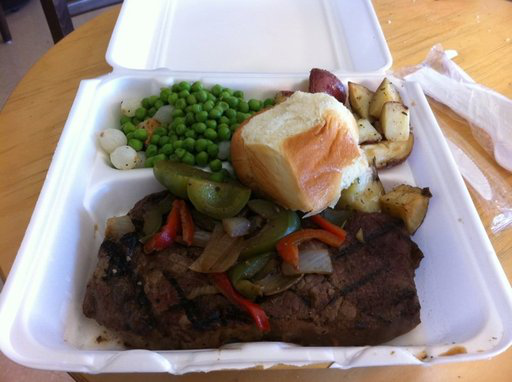

In [52]:
# Visualize an image
import random
from PIL import Image

# Get all images with glob
image_path_list = list(image_path.glob("train/*/*.jpg"))

# Pick one image randomly
random_image_path = random.choice(image_path_list)

# Get image class from path name 
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

torch.Size([3, 382, 512])


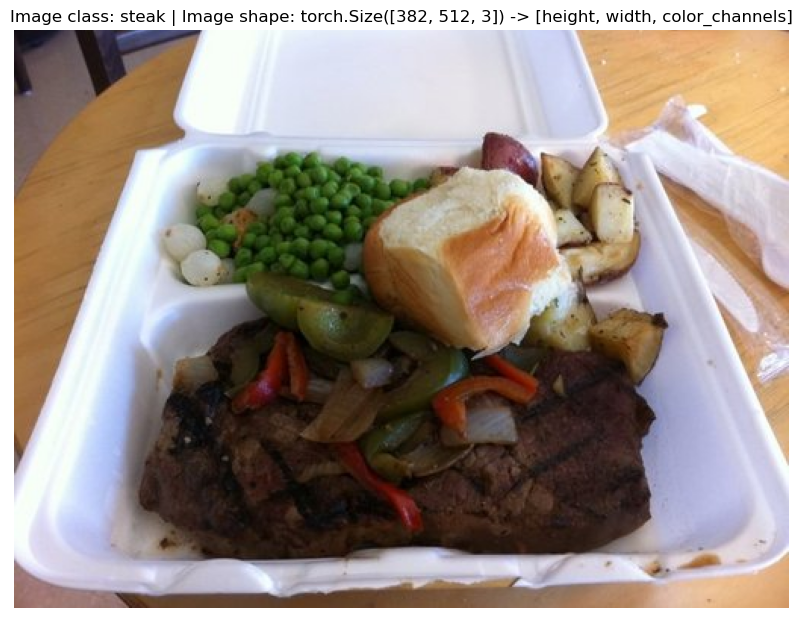

In [53]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt
from torchvision.io import read_image

image_tensor = read_image(random_image_path)
print(image_tensor.shape)

# Permute the channels for compatiblity with matplotlib
image_tensor = image_tensor.permute(1, 2, 0)

plt.figure(figsize=(10, 10))
plt.imshow(image_tensor)
plt.title(f"Image class: {image_class} | Image shape: {image_tensor.shape} -> [height, width, color_channels]")
plt.axis(False);


We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [ ]:
# 3.1 Transforming data with torchvision.transforms
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2

IM_SIZE = 64

train_transform = v2.Compose([
    v2.Resize((IM_SIZE, IM_SIZE)), # Resolution scaling
    v2.ToImage(), # To Tensor
    v2.TrivialAugmentWide(num_magnitude_bins=31), # Augmentation instead of horizontal flip
    v2.ToDtype(torch.float32, scale=True) # Normalizaton
])

test_transform = v2.Compose([
    v2.Resize((IM_SIZE, IM_SIZE)), # Resolution scaling
    v2.ToImage(), # To Tensor
    v2.ToDtype(torch.float32, scale=True) # Normalizaton
])

In [55]:
# Write transform for turning images into tensors


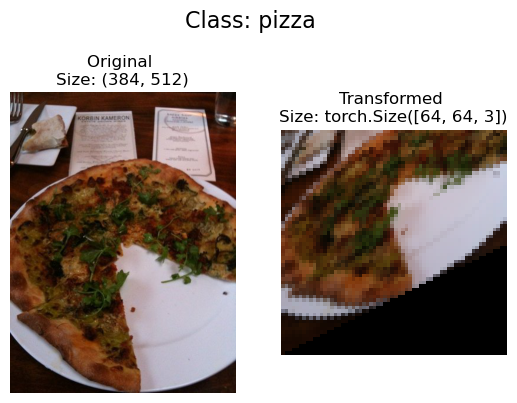

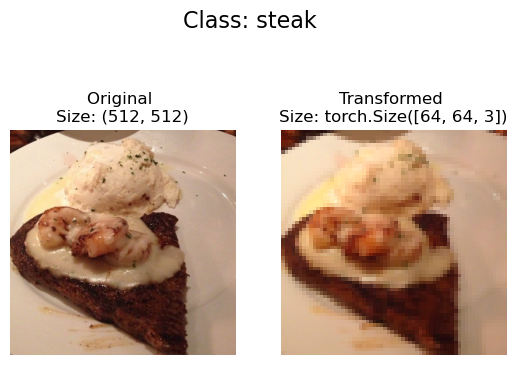

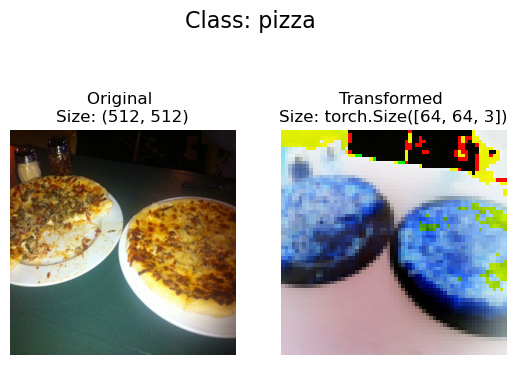

In [56]:
# Write a function to plot transformed images

#  Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

def plot_transformed_images_v2(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    #random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

# Plot random images
plot_transformed_images_v2(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

### Load image data using `ImageFolder`

In [57]:
# Use ImageFolder to create dataset(s)
from torchvision.datasets import ImageFolder
train_data = ImageFolder(root=train_path, transform=train_transform, target_transform=None)
test_data = ImageFolder(root=test_path, transform=test_transform)

In [58]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [59]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [60]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [61]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=os.cpu_count())

In [62]:
# How many batches of images are in our data loaders?
print("Number of batches in the training data loader: ", len(train_dataloader))

Number of batches in the training data loader:  8


In [63]:
image_test, label_test = next(iter(train_dataloader))

In [64]:
image_test.shape

torch.Size([32, 3, 64, 64])

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [65]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int, image_size: int) -> None:
        super().__init__()
        self.vector_len = image_size // 4 # Because there are two maxpool layers, each one reducing the resolution by 2.
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*self.vector_len*self.vector_len,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        #x = self.conv_block_1(x)
        ## print(x.shape)
        #x = self.conv_block_2(x)
        ## print(x.shape)
        #x = self.classifier(x)
        ## print(x.shape)
        #return x
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes),
                  image_size=IM_SIZE).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## 4. Create training and testing functions for `model_0`.

In [66]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
 
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred_logits = model(X)
    
    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred_logits, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred_logits)
   
  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  
  return train_loss, train_acc  

In [67]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
  
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
    
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred_logits = model(X)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(y_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      y_pred_labels = y_pred_logits.argmax(dim=1)
      test_acc += ((y_pred_labels == y).sum().item()/len(y_pred_labels))

    
  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  
  return test_loss, test_acc


In [68]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [69]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

model_0_results_epoch5 = train(model=model_0,
                               train_dataloader=train_dataloader,
                               test_dataloader=test_dataloader,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1069 | train_acc: 0.2578 | test_loss: 1.1004 | test_acc: 0.3333
Epoch: 2 | train_loss: 1.0788 | train_acc: 0.4258 | test_loss: 1.1132 | test_acc: 0.3333
Epoch: 3 | train_loss: 1.0811 | train_acc: 0.4258 | test_loss: 1.1298 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.1288 | train_acc: 0.3047 | test_loss: 1.1247 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0895 | train_acc: 0.4258 | test_loss: 1.1193 | test_acc: 0.3333


In [71]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

model_0_results_epoch20 = train(model=model_0,
                               train_dataloader=train_dataloader,
                               test_dataloader=test_dataloader,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1002 | train_acc: 0.4336 | test_loss: 1.0944 | test_acc: 0.3333
Epoch: 2 | train_loss: 1.0810 | train_acc: 0.4258 | test_loss: 1.0966 | test_acc: 0.3333
Epoch: 3 | train_loss: 1.0700 | train_acc: 0.4258 | test_loss: 1.1113 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.1134 | train_acc: 0.3047 | test_loss: 1.1089 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0748 | train_acc: 0.4883 | test_loss: 1.1109 | test_acc: 0.3067
Epoch: 6 | train_loss: 1.0804 | train_acc: 0.3789 | test_loss: 1.1041 | test_acc: 0.3733
Epoch: 7 | train_loss: 1.0181 | train_acc: 0.5469 | test_loss: 1.0892 | test_acc: 0.3867
Epoch: 8 | train_loss: 1.0253 | train_acc: 0.5156 | test_loss: 1.0668 | test_acc: 0.3867
Epoch: 9 | train_loss: 1.0285 | train_acc: 0.4492 | test_loss: 1.0430 | test_acc: 0.3867
Epoch: 10 | train_loss: 1.0316 | train_acc: 0.4453 | test_loss: 1.0031 | test_acc: 0.4800
Epoch: 11 | train_loss: 0.9978 | train_acc: 0.5078 | test_loss: 1.0985 | test_acc: 0.3467
Epoch: 12 | train_l

In [72]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

model_0_results_epoch50 = train(model=model_0,
                               train_dataloader=train_dataloader,
                               test_dataloader=test_dataloader,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9394 | train_acc: 0.4688 | test_loss: 1.0102 | test_acc: 0.3733
Epoch: 2 | train_loss: 0.8846 | train_acc: 0.6016 | test_loss: 1.0350 | test_acc: 0.4000
Epoch: 3 | train_loss: 0.8752 | train_acc: 0.6094 | test_loss: 1.0315 | test_acc: 0.4400
Epoch: 4 | train_loss: 0.8072 | train_acc: 0.6133 | test_loss: 1.0174 | test_acc: 0.3867
Epoch: 5 | train_loss: 0.8200 | train_acc: 0.6523 | test_loss: 1.0248 | test_acc: 0.4000
Epoch: 6 | train_loss: 0.9794 | train_acc: 0.4453 | test_loss: 1.0488 | test_acc: 0.4000
Epoch: 7 | train_loss: 0.8051 | train_acc: 0.6289 | test_loss: 0.9989 | test_acc: 0.4933
Epoch: 8 | train_loss: 0.8987 | train_acc: 0.6719 | test_loss: 1.0192 | test_acc: 0.4133
Epoch: 9 | train_loss: 0.8909 | train_acc: 0.5156 | test_loss: 1.0348 | test_acc: 0.3733
Epoch: 10 | train_loss: 0.9640 | train_acc: 0.4922 | test_loss: 1.0276 | test_acc: 0.4133
Epoch: 11 | train_loss: 0.9078 | train_acc: 0.5703 | test_loss: 1.1083 | test_acc: 0.4533
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [78]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=20, 
                  output_shape=len(train_data.classes),
                  image_size=IM_SIZE).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), 
                             lr=0.001)

model_1_results_epoch20 = train(model=model_1,
                               train_dataloader=train_dataloader,
                               test_dataloader=test_dataloader,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=20)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1092 | train_acc: 0.4180 | test_loss: 1.0953 | test_acc: 0.3333
Epoch: 2 | train_loss: 1.1299 | train_acc: 0.3047 | test_loss: 1.0903 | test_acc: 0.3333
Epoch: 3 | train_loss: 1.1000 | train_acc: 0.3047 | test_loss: 1.0986 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0969 | train_acc: 0.4453 | test_loss: 1.0985 | test_acc: 0.4400
Epoch: 5 | train_loss: 1.0978 | train_acc: 0.3398 | test_loss: 1.0991 | test_acc: 0.3867
Epoch: 6 | train_loss: 1.0967 | train_acc: 0.3125 | test_loss: 1.1026 | test_acc: 0.3733
Epoch: 7 | train_loss: 1.0692 | train_acc: 0.4844 | test_loss: 1.1156 | test_acc: 0.3333
Epoch: 8 | train_loss: 1.1194 | train_acc: 0.3047 | test_loss: 1.0977 | test_acc: 0.3733
Epoch: 9 | train_loss: 1.0923 | train_acc: 0.3633 | test_loss: 1.0862 | test_acc: 0.3467
Epoch: 10 | train_loss: 1.0744 | train_acc: 0.3281 | test_loss: 1.0683 | test_acc: 0.3867
Epoch: 11 | train_loss: 1.1020 | train_acc: 0.3242 | test_loss: 1.0701 | test_acc: 0.4267
Epoch: 12 | train_l

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [74]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

data\pizza_steak_sushi_20_percent directory exists.
Unzipping pizza, steak, sushi 20% data...


In [75]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi_20_percent\test'.
There are 0 directories and 46 images in 'data\pizza_steak_sushi_20_percent\test\pizza'.
There are 0 directories and 58 images in 'data\pizza_steak_sushi_20_percent\test\steak'.
There are 0 directories and 46 images in 'data\pizza_steak_sushi_20_percent\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi_20_percent\train'.
There are 0 directories and 154 images in 'data\pizza_steak_sushi_20_percent\train\pizza'.
There are 0 directories and 146 images in 'data\pizza_steak_sushi_20_percent\train\steak'.
There are 0 directories and 150 images in 'data\pizza_steak_sushi_20_percent\train\sushi'.


Excellent, we now have double the training and testing images... 

In [76]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

In [79]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

#simple_transform = transforms.Compose([
#  transforms.Resize((64, 64)),                                     
#  transforms.ToTensor()
#])

# Create datasets
train_data_20 = ImageFolder(root=train_data_20_percent_path, transform=train_transform, target_transform=None)
test_data_20 = ImageFolder(root=test_data_20_percent_path, transform=test_transform)

# Create dataloaders
BATCH_SIZE = 32
train_dataloader_20 = DataLoader(train_data_20, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_dataloader_20 =  DataLoader(test_data_20, batch_size=1, shuffle=False, num_workers=os.cpu_count())

In [ ]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=20, 
                  output_shape=len(train_data.classes),
                  image_size=IM_SIZE).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), 
                             lr=0.001)

model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader_20,
                        test_dataloader=test_dataloader_20,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1045 | train_acc: 0.3396 | test_loss: 1.0988 | test_acc: 0.3067
Epoch: 2 | train_loss: 1.0968 | train_acc: 0.3375 | test_loss: 1.0930 | test_acc: 0.3200
Epoch: 3 | train_loss: 1.0735 | train_acc: 0.3792 | test_loss: 1.0218 | test_acc: 0.4333
Epoch: 4 | train_loss: 1.0261 | train_acc: 0.4792 | test_loss: 0.9576 | test_acc: 0.5400
Epoch: 5 | train_loss: 1.0079 | train_acc: 0.4604 | test_loss: 0.9043 | test_acc: 0.5533
Epoch: 6 | train_loss: 0.9363 | train_acc: 0.5188 | test_loss: 1.0421 | test_acc: 0.4667
Epoch: 7 | train_loss: 1.0592 | train_acc: 0.4771 | test_loss: 0.9653 | test_acc: 0.4867
Epoch: 8 | train_loss: 0.9599 | train_acc: 0.5542 | test_loss: 0.8668 | test_acc: 0.6333
Epoch: 9 | train_loss: 0.9690 | train_acc: 0.5062 | test_loss: 0.8601 | test_acc: 0.6133
Epoch: 10 | train_loss: 0.8935 | train_acc: 0.5458 | test_loss: 0.9333 | test_acc: 0.5400
Epoch: 11 | train_loss: 0.9245 | train_acc: 0.5542 | test_loss: 0.8380 | test_acc: 0.6533
Epoch: 12 | train_l

50 epochs: overfits

In [82]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_3 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=20, 
                  output_shape=len(train_data.classes),
                  image_size=IM_SIZE).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3.parameters(), 
                             lr=0.001)

model_3_results = train(model=model_3,
                        train_dataloader=train_dataloader_20,
                        test_dataloader=test_dataloader_20,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=22)

  0%|          | 0/22 [00:00<?, ?it/s]

Exception ignored in: Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\lib\multiprocessing\queues.py", line 239, in _feed
<function _ConnectionBase.__del__ at 0x0000021E9FCC3490>
Traceback (most recent call last):
  File "c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\lib\multiprocessing\connection.py", line 132, in __del__
    reader_close()
  File "c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\lib\multiprocessing\connection.py", line 177, in close
    self._close()
  File "c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\lib\multiprocessing\connection.py", line 277, in _close
    self._close()
  File "c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\ssre_\.conda\envs\.v

Epoch: 1 | train_loss: 1.1045 | train_acc: 0.3396 | test_loss: 1.0987 | test_acc: 0.3067
Epoch: 2 | train_loss: 1.0964 | train_acc: 0.3583 | test_loss: 1.0938 | test_acc: 0.3133
Epoch: 3 | train_loss: 1.0742 | train_acc: 0.3708 | test_loss: 1.0229 | test_acc: 0.4267
Epoch: 4 | train_loss: 1.0239 | train_acc: 0.4896 | test_loss: 0.9450 | test_acc: 0.5467
Epoch: 5 | train_loss: 1.0032 | train_acc: 0.4750 | test_loss: 0.9129 | test_acc: 0.5267
Epoch: 6 | train_loss: 0.9413 | train_acc: 0.5083 | test_loss: 1.0705 | test_acc: 0.4733
Epoch: 7 | train_loss: 1.0613 | train_acc: 0.4500 | test_loss: 0.9588 | test_acc: 0.4933
Epoch: 8 | train_loss: 0.9793 | train_acc: 0.5062 | test_loss: 0.9011 | test_acc: 0.6333
Epoch: 9 | train_loss: 0.9807 | train_acc: 0.5292 | test_loss: 0.9042 | test_acc: 0.5867
Epoch: 10 | train_loss: 0.9184 | train_acc: 0.5563 | test_loss: 0.8669 | test_acc: 0.6133
Epoch: 11 | train_loss: 0.9228 | train_acc: 0.5396 | test_loss: 0.8565 | test_acc: 0.6133
Epoch: 12 | train_l

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?

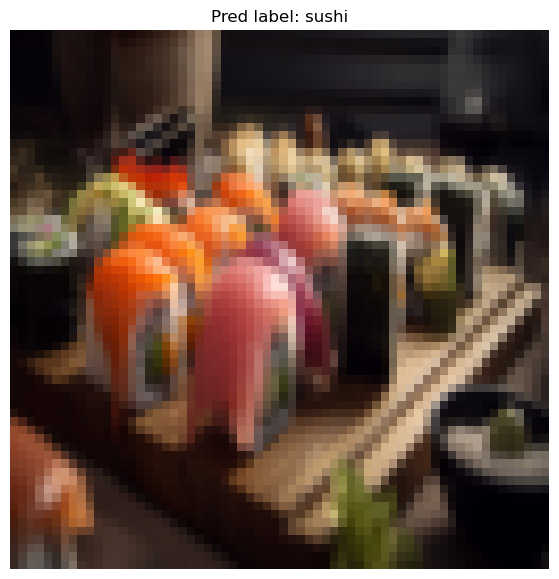

In [92]:
import torchvision
import torch
import torch
custom_image = data_path / "sushi_test.jpg"
img = torchvision.io.read_image(custom_image)
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in HWC (height, width, color_channels) format not CHW (color_channels, height, width)
plt.axis(False)

# Make a prediction on the image

simple_transform = v2.Compose([
    v2.Resize((64, 64)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

model_3.eval()
with torch.inference_mode():
  # Get image pixels into float + between 0 and 1
  img = simple_transform(img)

  ## Resize image to 64x64
  #resize = transforms.Resize((64, 64))
  #img = resize(img)

  # Turn image in single batch and pass to target device
  batch = img.unsqueeze(0).to(device)

  # Predict on image
  y_pred_logit = model_3(batch) 

  # Convert pred logit to pred label
  # pred_label = torch.argmax(torch.softmax(y_pred_logit, dim=1), dim=1)
  pred_label = torch.argmax(y_pred_logit, dim=1) # get same results as above without torch.softmax

# Plot the image and prediction
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Pred label: {class_names[pred_label]}")
plt.axis(False);